# A simple example for machine learning with uproot / coffea

Let's try to distinguish DY from ttW with just using rather low level inputs, and then compare to a simple M(ll) based discriminator.

In [69]:
import uproot
import awkward
import numpy as np
import pandas as pd
from uproot_methods import TLorentzVectorArray

from coffea.processor import LazyDataFrame
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf

In [70]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

In [71]:

# Load some prepared data
sig_file = uproot.open('/hadoop/cms/store/user/dspitzba/ML/DY.root')
bkg_file = uproot.open('/hadoop/cms/store/user/dspitzba/ML/bkg.root')

bkg_tree = bkg_file['Events']
sig_tree = sig_file['Events']
bkg = LazyDataFrame(bkg_tree, flatten=True)
sig = LazyDataFrame(sig_tree, flatten=True)

print ("Have %s signal events and %s background events"%(len(sig['MET_phi']), len(bkg['MET_phi'])))


Have 63189 signal events and 392177 background events


In [72]:
## Preprocessing data. This is rather slow, so probably building a custom data frame or dictionary would make more sense
#sig_df_in = sig_tree.pandas.df(flatten=False)
#bkg_df_in = bkg_tree.pandas.df(flatten=False)


In [73]:
def convertToDF( df ):

    eventSelection = ( (df['nLepton']==2) & (df['nVetoLepton']==2) )
    #df = df[eventSelection]
    
    jets = JaggedCandidateArray.candidatesfromcounts(
        df['nJet'],
        pt=df['Jet_pt'],
        eta=df['Jet_eta'],
        phi=df['Jet_phi'],
        mass=df['Jet_mass'],
        btag=df['Jet_btagDeepB'],
    )
    
    leptons = JaggedCandidateArray.candidatesfromcounts(
        df['nLepton'],
        pt=df['Lepton_pt'],
        eta=df['Lepton_eta'],
        phi=df['Lepton_phi'],
        mass= df['Lepton_mass'],
        charge=df['Lepton_pdgId']/abs(df['Lepton_pdgId'])
    )

    leadingJet = jets[jets.pt.argmax()]
    leadingJet = leadingJet[eventSelection]
    
    leptons = leptons[eventSelection]
    
    leadingLepton = leptons[leptons.pt.argmax()]
    
    subleadingLepton = leptons[leptons.pt.argmin()] # this works because we select events with just two leptons in the end
    
    dileptons = leptons.choose(2)
    
    met = pd.DataFrame({'pt':df['MET_pt'], 'phi':df['MET_phi']}) # there should be a better way than this, but otherwise can't select events
    
    met = met[eventSelection]
    
    return pd.DataFrame({
            'leadingJet_pt':leadingJet.pt.flatten(), 
            'lep0_pt':dileptons.i0.pt.flatten(),
            'lep0_eta':dileptons.i0.eta.flatten(),
            'lep0_phi':dileptons.i0.phi.flatten(),
            'lep0_charge':dileptons.i0.charge.flatten(),
            'lep0_mass':dileptons.i0.mass.flatten(),
            'lep1_pt':dileptons.i1.pt.flatten(),
            'lep1_eta':dileptons.i1.eta.flatten(),
            'lep1_phi':dileptons.i1.phi.flatten(),
            'lep1_charge':dileptons.i1.charge.flatten(),
            'lep1_mass':dileptons.i1.mass.flatten(),
            'mll': dileptons.mass.flatten(), 
            'dilepton_pt':dileptons.pt.flatten(),
            'MET_pt':met['pt'],
    })




In [74]:
sig_df = convertToDF( sig )
bkg_df = convertToDF( bkg )

In [75]:
#sig = sig_df_in[((sig_df_in['nLepton']==2) & (sig_df_in['nVetoLepton']==2))]
#sig_df = pd.DataFrame({'MET_pt': sig['MET_pt'], 'nGoodJet': sig['nGoodJet']})

#bkg = bkg_df_in[((bkg_df_in['nLepton']==2) & (bkg_df_in['nVetoLepton']==2))]
#bkg_df = pd.DataFrame({'MET_pt': bkg['MET_pt'], 'nGoodJet': bkg['nGoodJet']})

#print (len(my_bkg_df['MET_pt']))

In [76]:
# usually we have less signal than background
nSignal = len(sig_df['MET_pt'])

# Balance the signal and background sets
tmp_bkg_df = bkg_df.sample( n = nSignal )

y_sig = np.ones(len(sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

In [77]:
# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.5*y_tmp.shape[0] ), random_state=42 )

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [78]:
#variables = ['leadingJet_pt', 'leadingLepton_pt', 'subleadingLepton_pt', 'mll', 'dilepton_pt', 'MET_pt']
variables = ['lep0_pt', 'lep0_eta', 'lep0_phi', 'lep0_charge', 'lep0_mass', 'lep1_pt', 'lep1_eta', 'lep1_phi', 'lep1_charge', 'lep1_mass']
#variables = ['lep0_pt', 'lep0_eta', 'lep0_phi', 'lep0_mass', 'lep1_pt', 'lep1_eta', 'lep1_phi', 'lep1_mass']

X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]
X_myTest = X_tmp_test[['mll', 'MET_pt']]

In [79]:
NHLayer = 5
epochs = 1000
batch_size = 5120
validation_split = 0.2

# define the model. Which one is the best suited for our problem?
model = tf.keras.models.Sequential()

# add layers. we can play a bit with the hyper parameters here
model.add( tf.keras.layers.Dense(units=8, activation='relu', input_dim=X_train.shape[1], ))
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=128, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()

## Editor's note: don't go too crazy with nodes and layers if the data set is small or nothing will be learned at all.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_20 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_21 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 9         
Total params: 17,769
Trainable params: 17,769
Non-trainable params: 0
_________________________________________________________________


In [80]:
# verbose set to 0 (1 shows all the epochs)

history = model.fit(X_train.values, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)
model.save( 'training.h5a' )

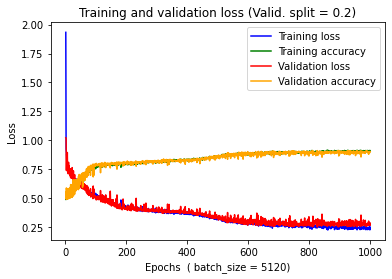

In [81]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)
        
plt.plot(epochslist, loss_values, 'b', label='Training loss')
plt.plot(epochslist, acc_values,'b', color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'b', color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'b', color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

In [82]:
# use the model to predict whether an event is signal or background
y_test_pred = pd.DataFrame( model.predict( X_test.values  ) , index = X_test.index)

# as a comparison, use a mll based discriminator:
y_test_pred_mll = (1-abs(X_myTest[['mll']]-91.2)/91.2).values.flatten()

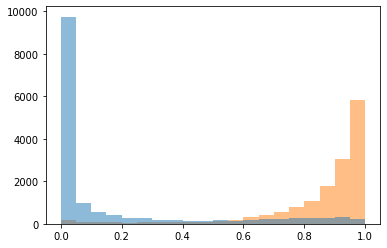

In [83]:
xbin = 20
hist, bins, ax = plt.hist( [ y_test_pred[y_test==0].values.flatten(), y_test_pred[y_test==1].values.flatten() ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5)

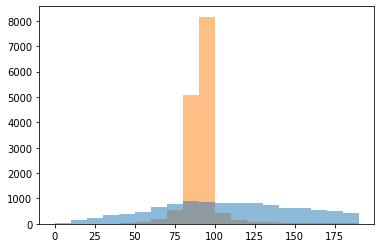

In [84]:
# just looking at M(ll)

xbin = range(0,200,10)
hist, bins, ax = plt.hist( [ X_myTest[['mll']][y_test==0].values.flatten(), X_myTest[['mll']][y_test==1].values.flatten() ], xbin, log=False, histtype='stepfilled', alpha=0.5) 

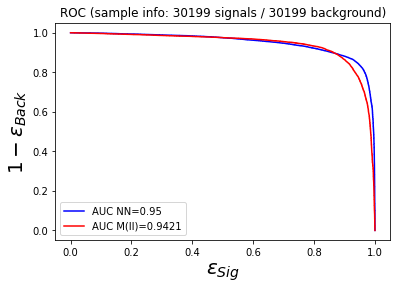

In [85]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN=' + str(round(auc_val_test,4) ))

fpr_test_alt, tpr_test_alt, thresholds_test_alt = roc_curve( y_test, y_test_pred_mll )
auc_val_test_alt = auc(fpr_test_alt, tpr_test_alt)

plt.plot( tpr_test_alt, 1-fpr_test_alt, 'b', label= 'AUC M(ll)=' + str(round(auc_val_test_alt,4) ), color='red')

plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')


Some observations:
- with small data set, the performance deterioates pretty quickly when the network becomes too complicated
- without using the lepton charge, the NN underperforms wrt M(ll), but gets quite close once the hyper parameters are (roughly) optimized
- overtraining seems to be not a big problem, and one can use a large number of epochs
- we still use a small data set
- maybe a different model is better suited for our problem?



# Using some physics knowledge (4 vectors)

We can try to use a network that knows about 4 vectors.

This is WIP!


In [61]:
from lbn import LBN, LBNLayer

In [62]:
def convertTo4Vec( df ):

    eventSelection = ( (df['nLepton']==2) & (df['nVetoLepton']==2) )
        
    leptons = JaggedCandidateArray.candidatesfromcounts(
        df['nLepton'],
        pt=df['Lepton_pt'],
        eta=df['Lepton_eta'],
        phi=df['Lepton_phi'],
        mass= df['Lepton_mass'],
        charge=df['Lepton_pdgId']/abs(df['Lepton_pdgId'])
    )
    
    leptons = leptons[eventSelection]
    
    dileptons = leptons.choose(2)
    
    #dileptons.i0.p4.energy # gives the energy
    
    leading = np.array(list(zip(dileptons.i0.p4.energy.flatten(), dileptons.i0.p4.x.flatten(),dileptons.i0.p4.y.flatten(),dileptons.i0.p4.z.flatten())))
    subleading = np.array(list(zip(dileptons.i1.p4.energy.flatten(), dileptons.i1.p4.x.flatten(),dileptons.i1.p4.y.flatten(),dileptons.i1.p4.z.flatten())))

    leps = np.array(list(zip(leading,subleading)))
    
    return leps # not yet sure how to do this. have to zip?

In [63]:
bkg = LazyDataFrame(bkg_tree, flatten=True)
sig = LazyDataFrame(sig_tree, flatten=True)


inputs_sig = convertTo4Vec( sig )
inputs_bkg = convertTo4Vec( bkg )

nSignal = len(inputs_sig)

# training
inputs_sig_train = inputs_sig[:int(nSignal/2)]
inputs_bkg_train = inputs_bkg[:int(nSignal/2)]

inputs = np.concatenate((inputs_sig_train,inputs_bkg_train))

# test
inputs_sig_test = inputs_sig[int(nSignal/2):nSignal]
inputs_bkg_test = inputs_bkg[int(nSignal/2):nSignal]

inputs_test = np.concatenate((inputs_sig_test,inputs_bkg_test))


# training
y_sig = np.ones(len(inputs_sig_train))
y_bkg = np.zeros(len(inputs_bkg_train))
y_tmp = np.concatenate((y_sig,y_bkg))

# test
y_sig_test = np.ones(len(inputs_sig_test))
y_bkg_test = np.zeros(len(inputs_bkg_test))
y_test = np.concatenate((y_sig_test,y_bkg_test))

print (np.shape(inputs))
print (np.shape(y_tmp))

(30198, 2, 4)
(30198,)


In [68]:
# start a sequential model
model = tf.keras.models.Sequential()

# add the LBN layer
lbn_layer = LBNLayer((2, 4), n_particles=2, boost_mode=LBN.PAIRS, features=["E", "px", "py", "pz"])

model.add(lbn_layer)

model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )

model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

#model.compile(loss="categorical_crossentropy")

features = model.predict(inputs)

AttributeError: module 'tensorflow' has no attribute 'random'

In [ ]:

history = model.fit(inputs, y_tmp, epochs=1000, batch_size=batch_size, validation_split=validation_split)

In [ ]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)
        
plt.plot(epochslist, loss_values, 'b', label='Training loss')
plt.plot(epochslist, acc_values,'b', color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'b', color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'b', color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

In [65]:
y_test_pred = pd.DataFrame( model.predict( inputs_test  ) )

TypeError: Sequential model cannot be built: model is empty. Add some layers first.

In [66]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )

ValueError: Found input variables with inconsistent numbers of samples: [30200, 30199]

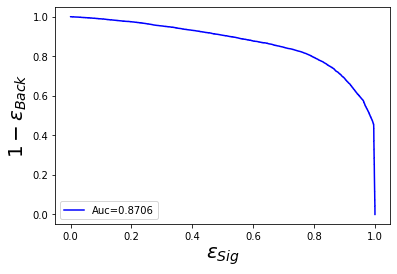

In [67]:
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'Auc=' + str(round(auc_val_test,4) ))

#plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
#                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')